In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,LeakyReLU, Activation, Concatenate, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img

In [2]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [3]:
def define_encoder_block(layer_in,n_filters,batchnorm=True):
    
    init=RandomNormal(stddev=0.02,seed=1)

    g=Conv2D(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    if batchnorm:
        g=BatchNormalization()(g,training=True)
    g=LeakyReLU(alpha=0.2)(g)
    
    return g

In [4]:
def define_decoder_block(layer_in,skip_in,n_filters,dropout=True):
    
    init=RandomNormal(stddev=0.02,seed=1)

    g=Conv2DTranspose(n_filters,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(layer_in)
    g=BatchNormalization()(g,training=True)
    if dropout:
        g=Dropout(0.5)(g,training=True)
    g=Concatenate()([g,skip_in])
    g=Activation('relu')(g)

    return g

In [5]:
def define_generator(image_shape=(256,256,3)):

    init=RandomNormal(stddev=0.02,seed=1)

    in_image=Input(shape=image_shape)

    e1=define_encoder_block(in_image,64,batchnorm=False)
    e2=define_encoder_block(e1,128)
    e3=define_encoder_block(e2,256)
    e4=define_encoder_block(e3,512)
    e5=define_encoder_block(e4,512)
    e6=define_encoder_block(e5,512)
    e7=define_encoder_block(e6,512)

    b=Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(e7)
    b=Activation('relu')(b)

    d1=define_decoder_block(b,e7,512)
    d2=define_decoder_block(d1,e6,512)
    d3=define_decoder_block(d2,e5,512)
    d4=define_decoder_block(d3,e4,512,dropout=False)
    d5=define_decoder_block(d4,e3,256,dropout=False)
    d6=define_decoder_block(d5,e2,128,dropout=False)
    d7=define_decoder_block(d6,e1,64,dropout=False)

    g=Conv2DTranspose(image_shape[2],(4,4),strides=(2,2),padding='same',kernel_initializer=init)(d7)
    out_image=Activation('tanh')(g)

    model=Model(in_image,out_image)
    return model

In [6]:
def generate_real_samples(n_sample,patch_shape,path_in='./processed_dataset/image_gan_in_final/',path_out='./processed_dataset/image_gan_out_final/',test=False):

    start=0
    end=70001
    if (test):
        start=70001
        end=80788
    ix=np.random.randint(start,end,n_sample)

    X1,X2=list(),list()
    red_mask=np.array([1,0,0])
    green_mask=np.array([0,1,0])
    
    for i in ix:
        pixels_in=load_img(path_in+f"{i}.png")
        pixels_in=np.array(pixels_in)
        pixels_in=pixels_in/255.0
        X1.append(pixels_in)
        pixels_out=load_img(path_out+f"{i}.png")
        pixels_out=np.array(pixels_out)
        pixels_out=pixels_out/255.0
        X2.append(pixels_out)

    y=np.ones((n_sample,patch_shape,patch_shape,1))

    return [np.array(X1),np.array(X2)],y

In [7]:
path_in='./processed_dataset/image_gan_in_final/'
path_out='./processed_dataset/image_gan_out_final/'

[src_images,tar_images],_=generate_real_samples(10,1,test=True)
print('Loaded: ',src_images.shape,tar_images.shape)

Loaded:  (10, 256, 256, 3) (10, 256, 256, 3)


In [8]:
g_model=define_generator()

In [22]:
g_model.load_weights(r"C:\Users\Sagar\Python files_Jupiter\Git Repo Local\GAN Architectural Model\gan_results\g_models\g_model_052000.h5")

In [23]:
res=g_model.predict(src_images)

1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


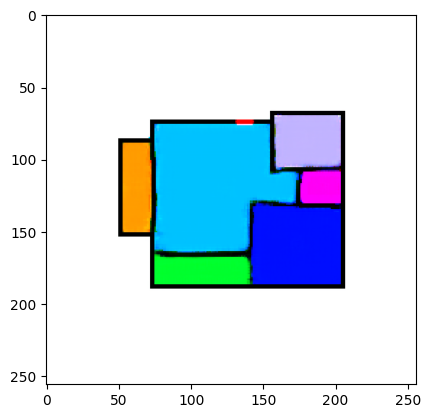

In [25]:
plt.imshow(res[9])

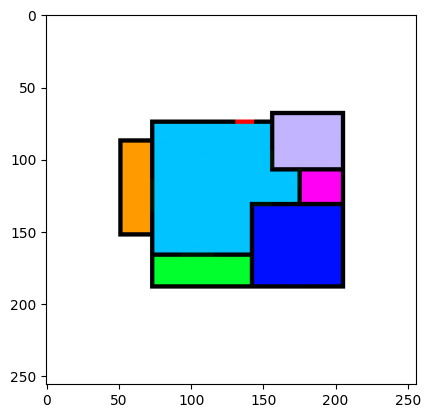

In [26]:
plt.imshow(tar_images[9])